In [1]:
import sys 
sys.path.append('..')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import torch as ch
from torch import Tensor
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader
from delphi.stats.truncated_regression import truncated_regression
from delphi.utils.datasets import TruncatedRegressionDataset
from delphi.oracle import Left, Interval
import datetime

In [37]:
STORE_PATH = '/home/pstefanou/fewerEpochs'
STORE_TABLE_NAME = 'fewepochs2'

store = Store(STORE_PATH)

store.add_table(STORE_TABLE_NAME, { 
    'known_param_mse': float,
    'unknown_param_mse': float, 
    'ols_param_mse': float,
    'alpha': float, 
    'var': float, 
})

Logging in: /home/pstefanou/fewerEpochs/778743fb-d5bf-45f1-93fe-f12ab3a582a1


In [ ]:
# regression parameters
num_samples, dims = 10000, 10
W = ch.ones(dims, 1)
W0 = ch.ones(1, 1)
phi = Left(Tensor([1.0]))

# begin experiment
start = datetime.datetime.now()

# perform each experiment a total of 10 times
for iter_ in range(10):        
    for var in range(1, 20):
        # generate data
        X = MultivariateNormal(ch.zeros(dims), ch.eye(dims)/dims).sample(ch.Size([num_samples]))
        y = X.mm(W) + W0 + Normal(ch.zeros(1), ch.sqrt(Tensor([var]))).sample(ch.Size([num_samples]))
        # truncate
        indices = phi(y).nonzero(as_tuple=False).flatten()
        y_trunc, x_trunc = y[indices], X[indices]
        
        # empirical linear regression
        reg = LinearRegression() 
        reg.fit(x_trunc, y_trunc)
        emp_var = ch.var(ch.from_numpy(reg.predict(x_trunc)) - y_trunc, dim=0).unsqueeze(0)
        
        # experiment parameters
        args = Parameters({ 
            'alpha': Tensor([y_trunc.size(0)/num_samples]), 
            'phi': phi, 
            'epochs': 10,
            'num_workers': 20, 
            'batch_size': 100,
            'bias': True,
            'num_samples': 100,
            'clamp': True, 
            'radius': 5.0, 
            'var_lr': 1e-2,
            'var': emp_var,
            'lr': 1e-1,
            'shuffle': True
        })


        # truncated linear regression with known noise variance
        # dataset 
        data = TruncatedRegressionDataset(x_trunc, y_trunc, bias=args.bias, unknown=False)
        S = DataLoader(data, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=args.shuffle)
        trunc_reg = truncated_regression(phi=phi, alpha=args.alpha, epochs=args.epochs, var_lr=args.var_lr, lr=args.lr, num_samples=args.num_samples, var=args.var)
        results = trunc_reg.fit(S)
        w_, w0_ = results.weight.detach(), results.bias.detach()

        # truncated linear regression with unknown noise variance
        # dataset 
        data = TruncatedRegressionDataset(x_trunc, y_trunc, bias=args.bias, unknown=True)
        S = DataLoader(data, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=args.shuffle)
        trunc_reg = truncated_regression(phi=phi, alpha=args.alpha, epochs=args.epochs, var_lr=args.var_lr, lr=args.lr, num_samples=args.num_samples)

        results = trunc_reg.fit(S)
        var_ = results.lambda_.inverse().detach()
        w, w0 = results.v.detach()*var_, results.bias.detach()*var_
        
        # calculate metrics 
        real_params = ch.cat([W, W0])
        ols_params = ch.cat([data.w, data.w0.unsqueeze(0)])
        unknown_params = ch.cat([w, w0])
        known_params = ch.cat([w_.t(), w0_.unsqueeze(0)])
        unknown_param_mse = mean_squared_error(unknown_params, real_params)
        ols_param_mse = mean_squared_error(ols_params, real_params)
        known_param_mse = mean_squared_error(known_params, real_params)

        store[STORE_TABLE_NAME].append_row({ 
            'known_param_mse': known_param_mse,
            'unknown_param_mse': unknown_param_mse,
            'ols_param_mse': ols_param_mse,
            'alpha': float(args.alpha.flatten()),
            'var': float(var), 
        })

# end experiment
end = datetime.datetime.now()
print("time delta: {}".format(end - start))

# close current store
store.close()

Epoch:1 | Loss 0.2649 | Train1 0.273 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 49/49 [00:00<00:00, 101.50it/s]
Epoch:2 | Loss 0.2696 | Train1 0.273 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 49/49 [00:00<00:00, 98.85it/s] 
Epoch:3 | Loss 0.2776 | Train1 0.273 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 49/49 [00:00<00:00, 94.06it/s]
Epoch:4 | Loss 0.2820 | Train1 0.278 | Train5 -1.000 | Reg term: 0.0 ||:   0%|          | 0/49 [00:00<?, ?it/s]

In [ ]:
reader = CollectionReader(STORE_PATH)
results = reader.df(STORE_TABLE_NAME)
results.head()

In [28]:
known, unknown, ols = results[['known_param_mse', 'var']], results[['unknown_param_mse', 'var']], results[['ols_param_mse', 'var']]

In [31]:
known_, unknown_, ols_ = known[known['var'] <= 15.0], unknown[unknown['var'] <= 15.0], ols[ols['var'] <=15.0]

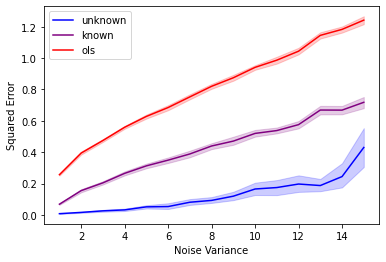

In [32]:
# plot results for regression parameter MSE
sns.lineplot(data=unknown_, x='var', y='unknown_param_mse', label='unknown', color='blue')
sns.lineplot(data=known_, x='var', y='known_param_mse', label='known', color='purple')
ax = sns.lineplot(data=ols_, x='var', y='ols_param_mse', label='ols', color='red')
ax.set(xlabel='Noise Variance', ylabel='Squared Error')
plt.show()
# close reader
reader.close()

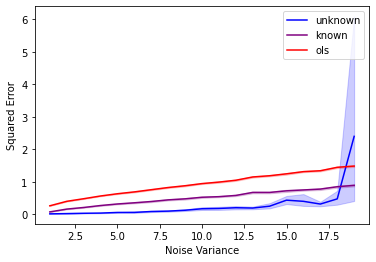

In [34]:
# plot results for regression parameter MSE
sns.lineplot(data=unknown, x='var', y='unknown_param_mse', label='unknown', color='blue')
sns.lineplot(data=known, x='var', y='known_param_mse', label='known', color='purple')
ax = sns.lineplot(data=ols, x='var', y='ols_param_mse', label='ols', color='red')
ax.set(xlabel='Noise Variance', ylabel='Squared Error')
plt.show()
# close reader
reader.close()

In [7]:
start = datetime.datetime.now()

In [9]:
delta = datetime.datetime.now() - start

445117